In [1]:
import torchvision
import torchvision.datasets as datasets

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.utils.prune as prune
import numpy as np
import copy
import torch
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
model_path = '/content/gdrive/My Drive/PR branch/model.pth'

Load Data

In [4]:
transform = transforms.ToTensor()

In [5]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(mnist_trainset , batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_trainset , batch_size = 100, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



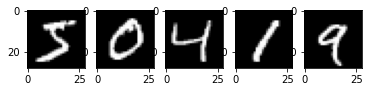

In [34]:
for i in range(5):
  plt.subplot(1, 5, i+1)
  d = mnist_trainset[i]
  plt.imshow(d[0][0] , cmap='gray'  ,vmin=0 , vmax = 1 )

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = F.log_softmax(self.fc1(x), dim=1)
        return x

In [7]:
def calc_accuracy(ml):
  test_loss = 0.0
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))

  ml.eval() 

  for data, target in test_loader:
      output = ml(data)
      _, pred = torch.max(output, 1)
      correct = np.squeeze(pred.eq(target.data.view_as(pred)))
      for i in range(100):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

  return np.sum(class_correct) / np.sum(class_total)

In [ ]:
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
n_epochs = 20  

model.train() 

for epoch in range(n_epochs):
    train_loss = 0.0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 1.147646
Epoch: 2 	Training Loss: 0.642589
Epoch: 3 	Training Loss: 0.535758
Epoch: 4 	Training Loss: 0.484437
Epoch: 5 	Training Loss: 0.453064
Epoch: 6 	Training Loss: 0.431302
Epoch: 7 	Training Loss: 0.415107
Epoch: 8 	Training Loss: 0.402422
Epoch: 9 	Training Loss: 0.392133
Epoch: 10 	Training Loss: 0.383664
Epoch: 11 	Training Loss: 0.376404
Epoch: 12 	Training Loss: 0.370112
Epoch: 13 	Training Loss: 0.364651
Epoch: 14 	Training Loss: 0.359748
Epoch: 15 	Training Loss: 0.355440
Epoch: 16 	Training Loss: 0.351535
Epoch: 17 	Training Loss: 0.347933
Epoch: 18 	Training Loss: 0.344766
Epoch: 19 	Training Loss: 0.341731
Epoch: 20 	Training Loss: 0.339019


In [ ]:
calc_accuracy(model)

0.90695

In [ ]:
torch.save(model.state_dict(), model_path)

In [ ]:
accuracyesl1 = []

for i in range(0,100):
  prun_model = Net()
  prun_model.load_state_dict(torch.load(model_path))
  prune.l1_unstructured(prun_model.fc1, 'weight', amount=i/100)
  accuracyesl1.append(calc_accuracy(prun_model))

<Figure size 432x288 with 0 Axes>

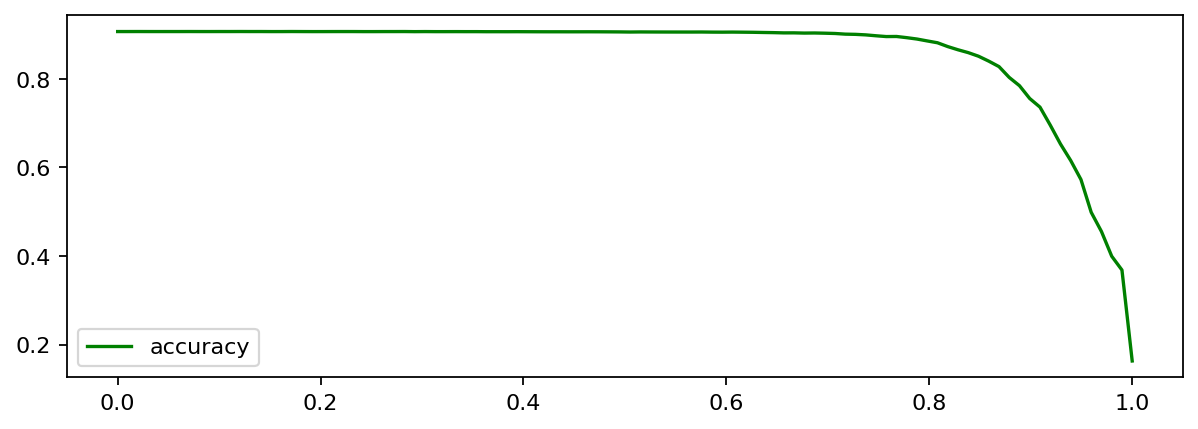

In [ ]:
plt.clf()
x = np.linspace(0,1,100)
plt.figure(figsize=(9,3),dpi=160)
plt.plot(x,accuracyesl1,'g',label="accuracy")
plt.legend()

In [ ]:
from sklearn import metrics
metrics.auc(x[:91], accuracyesl1[:91])

0.8147593434343435

In [11]:
data_set = [[]for i in range(10)]
for train_images, train_labels in train_loader:
  for image,label in zip(train_images, train_labels):
    data_set[label].append(image[0].numpy().flatten())

In [12]:
com_data = []
for class_data in data_set:
  for data in class_data:
    com_data.append(data)

In [10]:
def custom_pruning(mdl , stacked_mean_image , acc , k):
  
  with torch.no_grad():
    weights = np.asarray(torch.abs(copy.deepcopy(mdl.fc1.weight)))
    weights = (weights + (k*stacked_mean_image)).flatten()
    compression = int(stacked_mean_image.shape[0] * stacked_mean_image.shape[1]/100)
    arg = np.argsort(weights)
    counter = 0
    for i in range(1,100):
      for j in range(compression):
        idx = int(arg[counter])
        counter += 1
        i_index = int(idx / 784)
        j_index = int(idx % 784)
        mdl.fc1.weight[i_index][j_index] = 0
      acc.append(calc_accuracy(mdl))


In [13]:
var = np.var(np.array(com_data) , axis = 0)

In [14]:
mean_image = np.mean(np.array(com_data) , axis = 0)

In [15]:
hyper_data = np.multiply(mean_image.reshape((mean_image.shape[0], 1)) , var.reshape((var.shape[0], 1)))

In [16]:
mean_image_stacked = copy.deepcopy(hyper_data)
for i in range(9):
  mean_image_stacked = np.hstack((hyper_data , mean_image_stacked))
mean_image_stacked = mean_image_stacked.T

In [8]:
model = Net()
model.load_state_dict(torch.load(model_path))

custom_acc = []
custom_acc.append(calc_accuracy(model))

In [17]:
custom_pruning(model,mean_image_stacked,custom_acc , 0.1)

<Figure size 432x288 with 0 Axes>

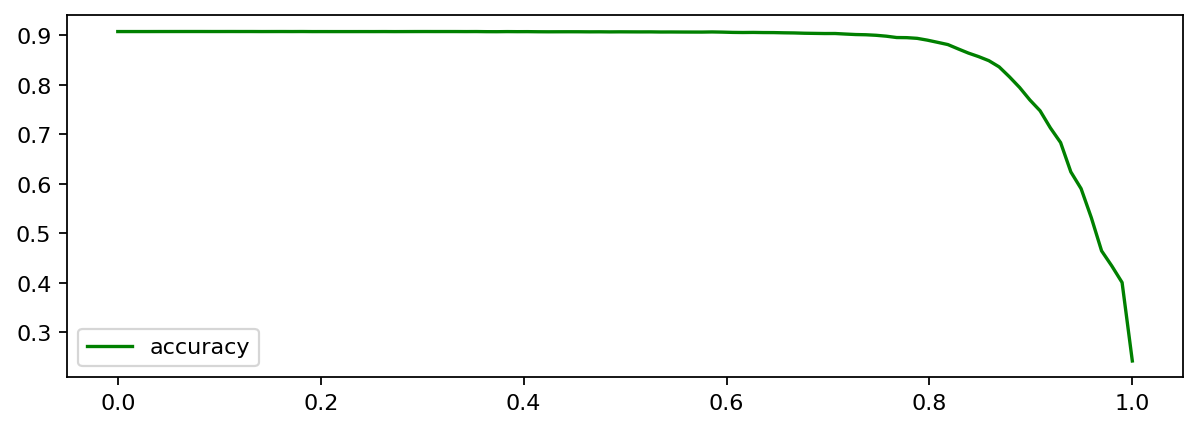

In [18]:
plt.clf()
x = np.linspace(0,1,100)
plt.figure(figsize=(9,3),dpi=160)
plt.plot(x,custom_acc,'g',label="accuracy")
plt.legend()

In [19]:
from sklearn import metrics
metrics.auc(x[:91], custom_acc[:91])

0.8157930976430977

In [ ]:
model = Net()
model.load_state_dict(torch.load(model_path))

custom_acc = []
custom_acc.append(calc_accuracy(model))

In [ ]:
custom_pruning(model,mean_image_stacked,custom_acc , 0.001)

<Figure size 432x288 with 0 Axes>

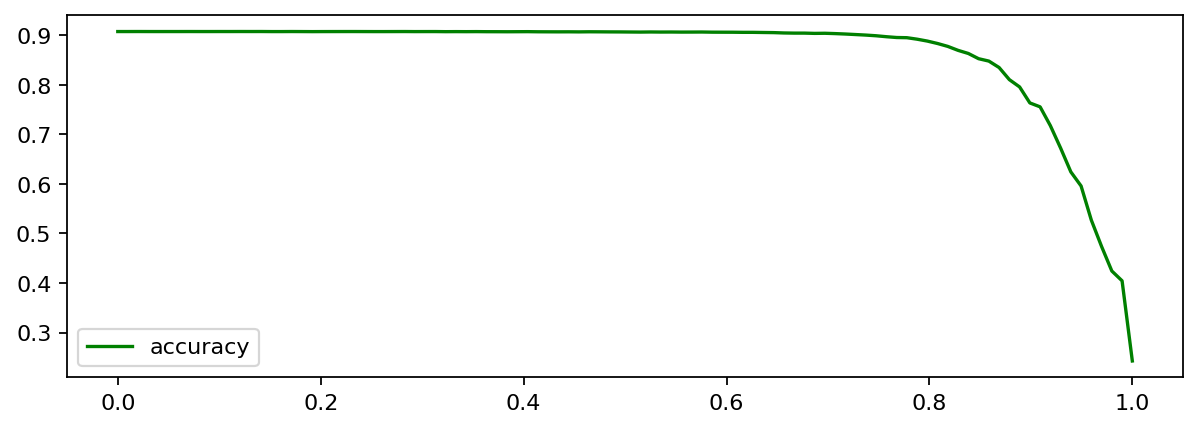

In [ ]:
plt.clf()
x = np.linspace(0,1,100)
plt.figure(figsize=(9,3),dpi=160)
plt.plot(x,custom_acc,'g',label="accuracy")
plt.legend()

In [ ]:
from sklearn import metrics
metrics.auc(x[:91], custom_acc[:91])

0.8154559764309766

In [20]:
model = Net()
model.load_state_dict(torch.load(model_path))

custom_acc = []
custom_acc.append(calc_accuracy(model))

In [21]:
custom_pruning(model,mean_image_stacked,custom_acc , 1)

<Figure size 432x288 with 0 Axes>

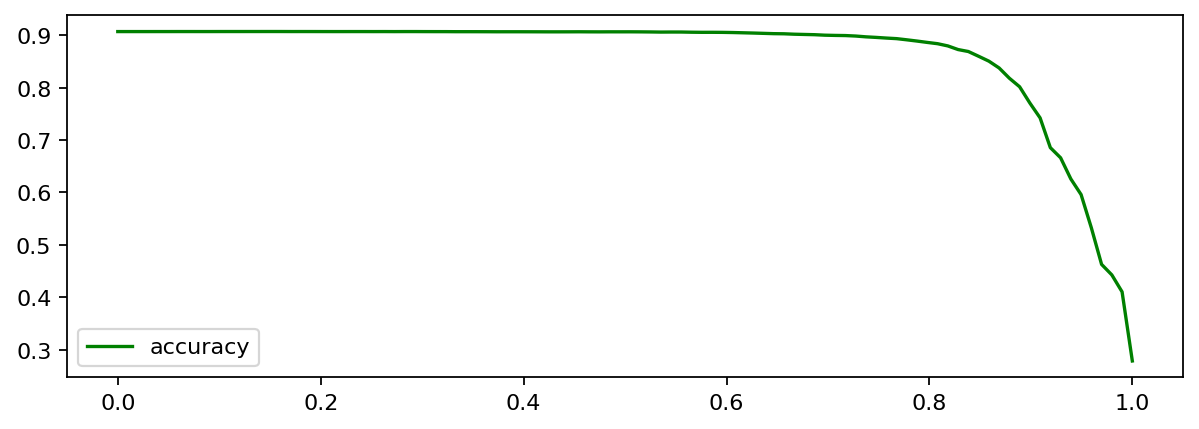

In [22]:
plt.clf()
x = np.linspace(0,1,100)
plt.figure(figsize=(9,3),dpi=160)
plt.plot(x,custom_acc,'g',label="accuracy")
plt.legend()

In [23]:
from sklearn import metrics
metrics.auc(x[:91], custom_acc[:91])

0.8154978956228957